In [2]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries
import torchtext
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator

# Models
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# Training
import torch.optim as optim

# Evaluation
from sklearn import preprocessing
import seaborn as sns

In [3]:
from Config import Config
from utils import *
from model import BERT
config = Config()


[-] Training Dataset: std_data/MCTest/Mc500/mc500.train.csv


In [4]:
# # Parameters
destination_folder = 'Model/'
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [12]:
# Model parameter
MAX_SEQ_LEN = config.MAX_SEQ_LEN
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)



# TabularDataset
train, valid = prepare_data(
    device,
    config.MAX_SEQ_LEN,
    config.batch_size,
    train_csv)


Token indices sequence length is longer than the specified maximum sequence length for this model (586 > 512). Running this sequence through the model will result in indexing errors


In [13]:

def load_checkpoint(load_path, model,device):
    if load_path==None:
        return

    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')

    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']

In [19]:
best_model = BERT().to(device)
load_checkpoint(destination_folder + '/model.pt', best_model,device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultipleChoice: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly

1.3860648747947482

In [35]:
model = best_model
#test_loader = test_iter
#Evaluate
y_pred = []
y_true = []

model.eval()
with torch.no_grad():
    for ( labels, A,B,C,D), _ in train:
        labels = labels.type(torch.LongTensor)           
        labels = labels.to(device)

        model_input = torch.stack([A,B,C,D],1)
        model_input = model_input.type(torch.LongTensor).to(device)

        output = model(model_input, labels)

        _, output = output
        y_pred.extend(torch.argmax(output, 1).tolist())
        y_true.extend(labels.tolist())
    for ( labels, A,B,C,D), _ in valid:
        labels = labels.type(torch.LongTensor)           
        labels = labels.to(device)

        model_input = torch.stack([A,B,C,D],1)
        model_input = model_input.type(torch.LongTensor).to(device)

        output = model(model_input, labels)

        _, output = output
        y_pred.extend(torch.argmax(output, 1).tolist())
        y_true.extend(labels.tolist())

In [51]:
print('Classification Report:')
print(classification_report(le.inverse_transform(y_true), le.inverse_transform(y_pred), labels=le.classes_))

Classification Report:
              precision    recall  f1-score   support

           A       0.34      0.35      0.34       288
           B       0.34      0.35      0.35       283
           C       0.36      0.37      0.36       303
           D       0.37      0.35      0.36       326

    accuracy                           0.35      1200
   macro avg       0.35      0.35      0.35      1200
weighted avg       0.35      0.35      0.35      1200



[Text(0, 0.5, 'A'), Text(0, 1.5, 'B'), Text(0, 2.5, 'C'), Text(0, 3.5, 'D')]

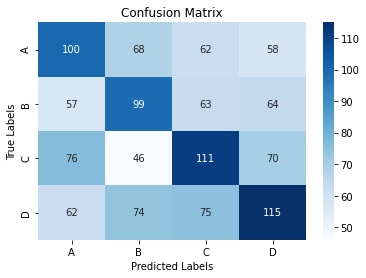

In [52]:
cm = confusion_matrix(le.inverse_transform(y_true), le.inverse_transform(y_pred), labels=le.classes_)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(le.classes_)
ax.yaxis.set_ticklabels(le.classes_)